In [1]:
import numpy as np

import matplotlib.pyplot as plt

from astropy.modeling import models
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
import astropy.units as u
from astropy.modeling.models import math
from gwcs.wcs import WCS as gWCS
from gwcs.spectroscopy import WavelengthFromGratingEquation
from photutils.datasets import apply_poisson_noise

from specreduce.calibration_data import load_pypeit_calibration_lines
from specreduce.utils.synth_data import make_2d_arc_image, make_2d_spec_image

In [2]:
%load_ext autoreload
%autoreload 2

np.random.seed(8675309)

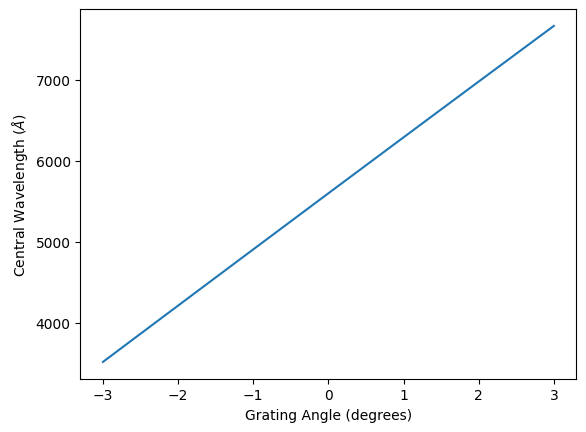

In [34]:
# model the MMTO Blue Channel spectrograph with the 500 l/mm grating in 1st order
bc_model = WavelengthFromGratingEquation(groove_density=500/u.mm, spectral_order=1)
blaze_angle = 8.05 * u.deg
grating_angle = np.linspace(3, -3, 100) * u.deg
alpha = (math.Deg2radUfunc() | math.SinUfunc())(blaze_angle + grating_angle)
beta = (math.Deg2radUfunc() | math.SinUfunc())(blaze_angle + grating_angle)
central_wavelength = bc_model(alpha, beta).to(u.angstrom)
plt.plot(grating_angle, central_wavelength)
plt.xlabel('Grating Angle (degrees)')
plt.ylabel("Central Wavelength ($\\AA$)")
plt.show()

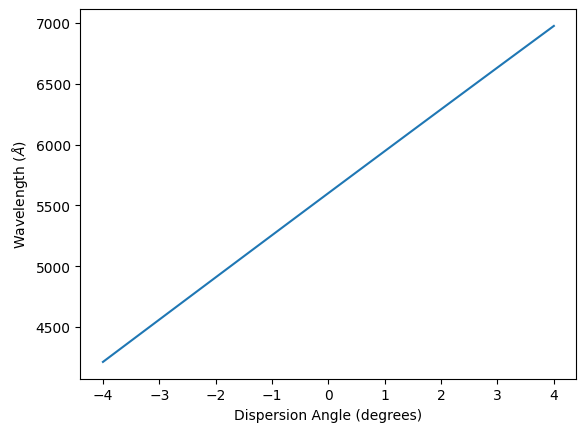

In [33]:
dispersion_angle = np.linspace(-4, 4, 100) * u.deg
alpha = (math.Deg2radUfunc() | math.SinUfunc())(blaze_angle)
beta = (math.Deg2radUfunc() | math.SinUfunc())(blaze_angle + dispersion_angle)
wavelength = bc_model(alpha, beta).to(u.angstrom)
plt.plot(dispersion_angle, wavelength)
plt.xlabel('Dispersion Angle (degrees)')
plt.ylabel("Wavelength ($\\AA$)")
plt.show()

In [3]:
nx = 3000
ny = 1000
const = 5
noise = 5
width = 5
center = ny / 2
x = np.arange(nx)
y = np.arange(ny)
xx, yy = np.meshgrid(x, y)
profile = models.Moffat1D()
wave_unit = u.Angstrom
extent = [3500, 7000]

In [4]:
wcs = WCS(naxis=2)
wcs.wcs.ctype[0] = 'WAVE'
wcs.wcs.ctype[1] = 'PIXEL'
wcs.wcs.cunit[0] = wave_unit
wcs.wcs.cunit[1] = u.pixel
wcs.wcs.crval[0] = extent[0]
wcs.wcs.cdelt[0] = (extent[1] - extent[0]) / nx
wcs.wcs.crval[1] = 0
wcs.wcs.cdelt[1] = 1
wcs.spectral

WCS Keywords

Number of WCS axes: 1
CTYPE : 'WAVE'  
CRVAL : 3.5000000000000004e-07  
CRPIX : 0.0  
PC1_1  : 1.0  
CDELT : 1.1666666666666668e-10  
NAXIS : 0  0

In [5]:
ll = load_pypeit_calibration_lines('HeI')
ll

ion,wave,NIST,Instr,amplitude,Source
,Angstrom,,,,
str3,float64,int64,int64,int64,str20
HeI,3889.75,1,4,2565,kastb_600_PYPIT.json
HeI,4027.3292,1,4,153,kastb_600_PYPIT.json
HeI,4472.735,1,0,30,ALFOSC
HeI,4714.4644,1,4,275,kastb_600_PYPIT.json
HeI,4923.3053,1,4,656,kastb_600_PYPIT.json
HeI,5017.0772,1,4,2341,kastb_600_PYPIT.json
HeI,5877.249,1,0,1000,FORS2
HeI,6679.995,1,0,300,ALFOSC


In [6]:
#wcs.spectral.world_to_pixel(ll['wave'].value * ll['wave'].unit)
wcs.spectral.world_to_pixel(ll['wave'])

array([ 333.07142857,  450.99645714,  832.77285714, 1039.96948571,
       1218.97597143, 1299.35188571, 2036.642     , 2724.71      ,
       3056.54685714])

In [7]:
profile.amplitude = 10
profile.alpha = 0.1
trace_mod = models.Chebyshev1D(degree=3, c0=0, c1=50, c2=100)
trace = yy - center + trace_mod(xx/nx)
z = const + profile(trace)
noisy = apply_poisson_noise(z)

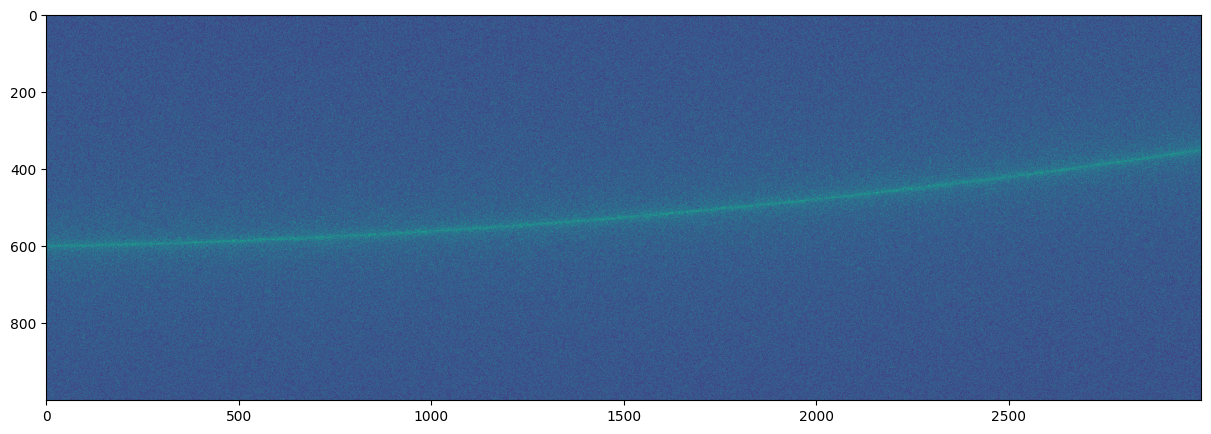

In [8]:
fig = plt.figure(figsize=(15, 5))
plt.imshow(noisy)
plt.show()

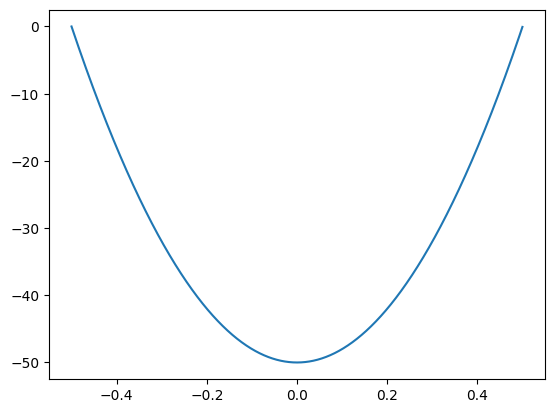

In [9]:
model2 = models.Legendre1D(degree=2, c0=50, c1=0, c2=100)
model1 = models.Legendre1D(degree=1, c0=0, c1=100)
model = models.Chebyshev1D(degree=2, c0=50, c1=0, c2=100)
x = (np.arange(3000)-1500)/3000
y = model(x)
plt.plot(x, y)

In [10]:
xx + model((yy/2 - yy)/ny)

array([[-5.00000000e+01, -4.90000000e+01, -4.80000000e+01, ...,
         2.94700000e+03,  2.94800000e+03,  2.94900000e+03],
       [-4.99999500e+01, -4.89999500e+01, -4.79999500e+01, ...,
         2.94700005e+03,  2.94800005e+03,  2.94900005e+03],
       [-4.99998000e+01, -4.89998000e+01, -4.79998000e+01, ...,
         2.94700020e+03,  2.94800020e+03,  2.94900020e+03],
       ...,
       [-2.99550000e-01,  7.00450000e-01,  1.70045000e+00, ...,
         2.99670045e+03,  2.99770045e+03,  2.99870045e+03],
       [-1.99800000e-01,  8.00200000e-01,  1.80020000e+00, ...,
         2.99680020e+03,  2.99780020e+03,  2.99880020e+03],
       [-9.99500000e-02,  9.00050000e-01,  1.90005000e+00, ...,
         2.99690005e+03,  2.99790005e+03,  2.99890005e+03]])

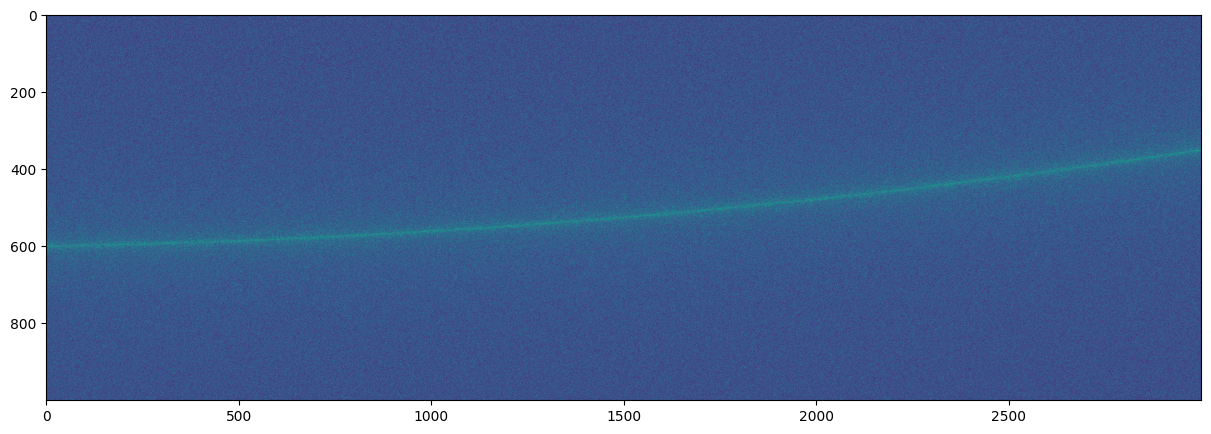

In [11]:
im = make_2dspec_image()
fig = plt.figure(figsize=(15, 5))
plt.imshow(im)

In [12]:
im = make_2d_arc_image(linelists=['HeI', 'ArI', 'ArII'], line_fwhm=3, tilt_func=model2)

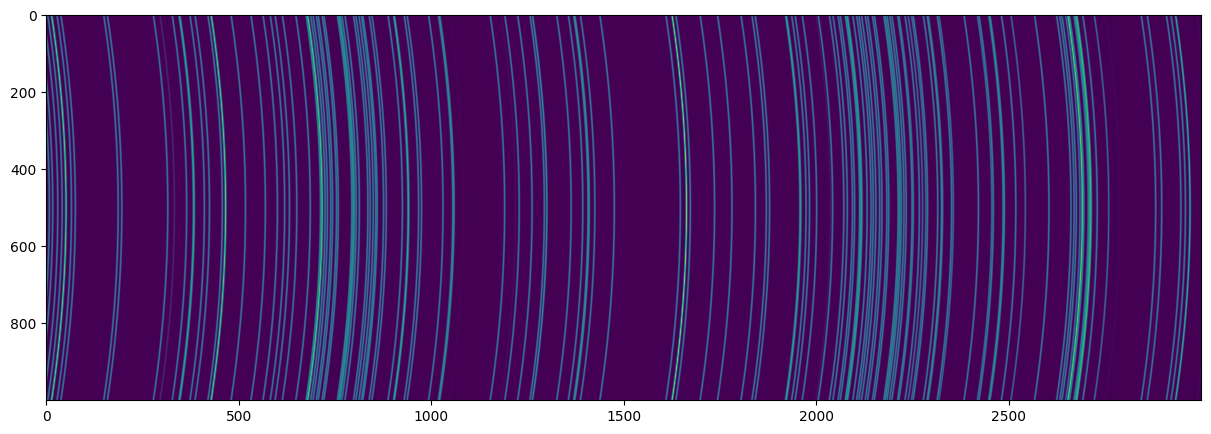

In [13]:
fig = plt.figure(figsize=(15, 5))
#ax = plt.subplot(projection=wcs)
#wave, pix = ax.coords
#wave.set_format_unit(u.um)
plt.imshow(im)

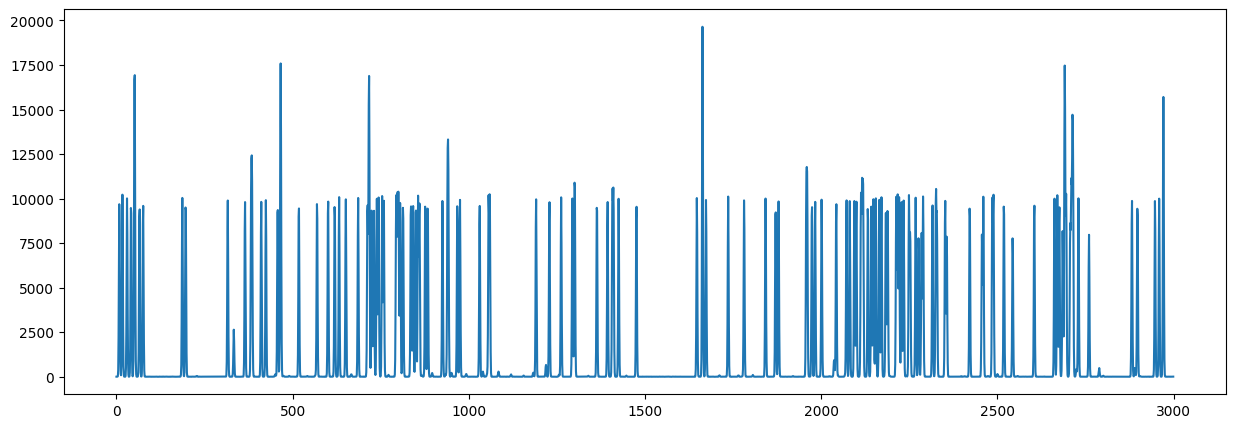

In [14]:
fig = plt.figure(figsize=(15, 5))
plt.plot(im.data[500, :])
plt.show()

In [26]:
non_linear_header = {
    'CTYPE1': 'AWAV-GRA',  # Grating dispersion function with air wavelengths
    'CUNIT1': 'Angstrom',  # Dispersion units
    'CRPIX1': 719.8,       # Reference pixel [pix]
    'CRVAL1': 7245.2,      # Reference value [Angstrom]
    'CDELT1': 2.956,       # Linear dispersion [Angstrom/pix]
    'PV1_0': 4.5e5,        # Grating density [1/m]
    'PV1_1': 1,            # Diffraction order
    'PV1_2': 27.0,         # Incident angle [deg]
    'PV1_3': 1.765,        # Reference refraction
    'PV1_4': -1.077e6,     # Refraction derivative [1/m]
    'CTYPE2': 'PIXEL',     # Spatial detector coordinates
    'CUNIT2': 'pix',       # Spatial units
    'CRPIX2': 1,           # Reference pixel
    'CRVAL2': 0,           # Reference value
    'CDELT2': 1            # Spatial units per pixel
}

linear_header = {
    'CTYPE1': 'AWAV',  # Grating dispersion function with air wavelengths
    'CUNIT1': 'Angstrom',  # Dispersion units
    'CRPIX1': 719.8,       # Reference pixel [pix]
    'CRVAL1': 7245.2,      # Reference value [Angstrom]
    'CDELT1': 2.956,       # Linear dispersion [Angstrom/pix]
    'CTYPE2': 'PIXEL',     # Spatial detector coordinates
    'CUNIT2': 'pix',       # Spatial units
    'CRPIX2': 1,           # Reference pixel
    'CRVAL2': 0,           # Reference value
    'CDELT2': 1            # Spatial units per pixel
}

non_linear_wcs = WCS(header=non_linear_header)
linear_wcs = WCS(header=linear_header)

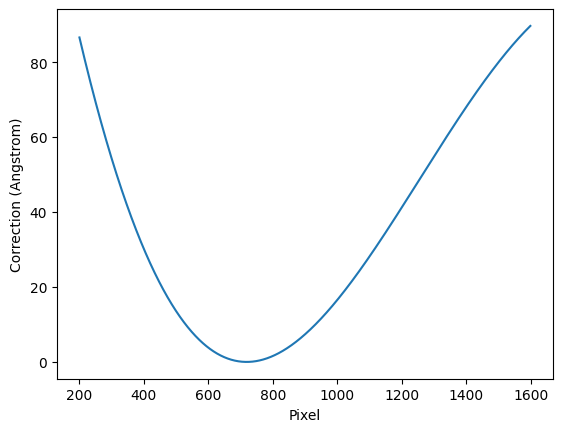

In [28]:
# this re-creates Paper III, Figure 5
pix_array = 200 + np.arange(1400)
nlin = non_linear_wcs.spectral.pixel_to_world(pix_array)
lin = linear_wcs.spectral.pixel_to_world(pix_array)
resid = (nlin - lin).to(u.Angstrom)
plt.plot(pix_array, resid)
plt.xlabel("Pixel")
plt.ylabel("Correction (Angstrom)")
plt.show()

In [24]:
linear_wcs.spectral.pixel_to_world(pix_array)

<SpectralCoord [nan, nan, nan, ..., nan, nan, nan] m>

In [25]:
linear_wcs.spectral

WCS Keywords

Number of WCS axes: 1
CTYPE : 'AWAV-GRA'  
CRVAL : 7.2452e-07  
CRPIX : 719.8  
PC1_1  : 1.0  
CDELT : 2.956e-10  
NAXIS : 0  0